# Oracle generation for 3-SAT problems

This notebook demonstrates Classiq's capabilities in the framework of phase oracles. The focus is 3-SAT problems on a growing number of variables. To highlight the advantage of generation times, we skip transpilation for the synthesis output.

The following function generates random 3-SAT problems for $N$ boolean variables, consisting of $N$ clauses.

In [2]:
import numpy as np


def generate_3sat_expression(num_qubits, max_iter=1000):
    """
    A function that generates 3sat expression with num_qubits clauses on num_qubits variables.
    We generate num_qubits triplets of the form (x_k or ~x_s1(k) or x_s2(k)), where s1, s2 are permutations
    """

    direct_arr = np.array([k for k in range(num_qubits)])
    vars = ["x" + str(k) for k in range(num_qubits)]
    negative_vars = ["~x" + str(k) for k in range(num_qubits)]

    for k in range(max_iter):
        permut1 = np.random.permutation(num_qubits)
        permut2 = np.random.permutation(num_qubits)
        if (
            (0 not in permut2 - direct_arr)
            and (0 not in permut1 - direct_arr)
            and (0 not in permut1 - permut2)
        ):
            break

    if k < max_iter:
        my_str = ""
        for k in range(num_qubits):
            my_str += (
                "("
                + vars[direct_arr[k]]
                + " or "
                + negative_vars[permut1[k]]
                + " or "
                + vars[permut2[k]]
                + ")and"
            )

        return my_str[0 : len(my_str) - 3]
    else:
        return ""

## 1. Generating Phase Oracles

For each 3-SAT problem we generate an oracle with Classiq and save the generation time. 

In [ ]:
def get_generation_time_classiq(expression, num_qubits):
    start_cl = time.time()
    params = ArithmeticOracle(
        expression=expression,
        definitions={vars[k]: RegisterUserInput(size=1) for k in range(num_qubits)},
        uncomputation_method="optimized",
    )
    model = Model(preferences=Preferences(transpilation_option="none"))
    model.ArithmeticOracle(params)
    quantum_program = synthesize(model.get_model())

    return time.time() - start_cl

In [ ]:
def get_generation_time_qiskit(expression, num_qubits):
    start_qs = time.time()
    oracle = PhaseOracle(expression)
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    qc.append(oracle, q[:])

    return time.time() - start_qs

*For generating the same data with Qiskit please uncomment the commented lines (including the `pip install command`).* 

In [3]:
import time

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PhaseOracle

from classiq import GeneratedCircuit, Model, RegisterUserInput, synthesize
from classiq.builtin_functions import ArithmeticOracle
from classiq.model import CustomHardwareSettings, Preferences

We generate two seperated lists for the number of variables, one with less than 23 variables and another with more. For the second list we could not generate data with Qiskit as generation times exponentially diverge with the number of variables.  

In [25]:
np.random.seed(128)
cl_times = []
num_qubits_list1 = [k for k in range(10, 23)]
num_qubits_list2 = [int(l) for l in np.logspace(np.log2(24), np.log2(90), 10, base=2)]

In [8]:
# ! pip install tweedledum
# qs_times = []
for l in num_qubits_list1:
    num_qubits = l
    print("num_qubits:", num_qubits)
    vars = ["x" + str(k) for k in range(num_qubits)]
    expression = generate_3sat_expression(num_qubits, max_iter=1000)

    classiq_generation_time = get_generation_time_classiq(expression, num_qubits)
    cl_times.append(classiq_generation_time)
    print("classiq_time:", classiq_generation_time)

    # qiskit_generation_time = get_generation_time_qiskit(expression, num_qubits)
    # qs_times.append(qiskit_generation_time)
    # print("qiskit_time:", qiskit_generation_time)


for l in num_qubits_list2:
    num_qubits = l
    print("num_qubits:", num_qubits)
    vars = ["x" + str(k) for k in range(num_qubits)]
    expression = generate_3sat_expression(num_qubits, max_iter=1000)

    classiq_generation_time = get_generation_time_classiq(expression, num_qubits)
    cl_times.append(classiq_generation_time)
    print("classiq_time:", classiq_generation_time)

## 2. Plotting the Data

Since generating the data takes time we hard-coded the qiskit results in the notebook. If you run this notebook by yourself please comment out the following cell.

In [ ]:
qs_times = [
    0.23147010803222656,
    0.2850170135498047,
    2.6256730556488037,
    0.75693678855896,
    5.783859968185425,
    3.3723957538604736,
    3.9280269145965576,
    39.92809295654297,
    60.67643904685974,
    16.551968097686768,
    31.536834955215454,
    31.086618900299072,
    794.9081449508667,
]

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
 [Text(0.1, 0, '$\\mathdefault{10^{-1}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$'),
  Text(10.0, 0, '$\\mathdefault{10^{1}}$'),
  Text(100.0, 0, '$\\mathdefault{10^{2}}$'),
  Text(1000.0, 0, '$\\mathdefault{10^{3}}$'),
  Text(10000.0, 0, '$\\mathdefault{10^{4}}$')])

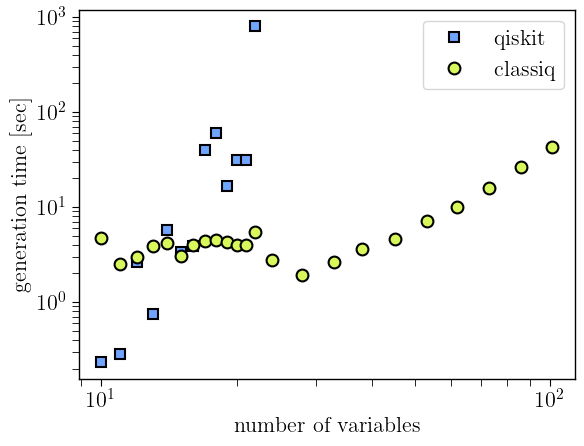

In [12]:
import matplotlib.pyplot as plt

classiq_color = "#D7F75B"
qiskit_color = "#6FA4FF"
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5


plt.loglog(
    num_qubits_list1,
    qs_times,
    "s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)
plt.loglog(
    num_qubits_list1 + num_qubits_list2,
    cl_times,
    "o",
    label="classiq",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8.5,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)

plt.legend(fontsize=16, loc="upper right")


plt.ylabel("generation time [sec]", fontsize=16)
plt.xlabel("number of variables", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)